In [23]:
import numpy as np
import matplotlib.pyplot as plt

def get_advanced_train_data():
    np.random.seed(42)
    n_samples = 600
    dist = np.random.uniform(50, 800, n_samples)
    hour = np.random.uniform(0, 23, n_samples)
    X = np.column_stack([dist, hour])
    
    # Non-linear delay: peaks at 8am and 6pm (rush hours)
    delay = 0.06 * dist + 15 * np.sin((hour - 8) * np.pi / 10)**2 + np.random.normal(0, 5, n_samples)
    y_reg = np.maximum(0, delay)
    
    # Classes: 0 (<15m), 1 (15-40m), 2 (>40m)
    y_multi = np.zeros(n_samples, dtype=int)
    y_multi[y_reg > 15] = 1
    y_multi[y_reg > 40] = 2
    
    return X, y_reg, y_multi

X, y_reg, y_multi = get_advanced_train_data()

# Enhanced Plotting Helper for Multi-class
def plot_multi_boundary(model, X, y, title):
    h = 2.0
    x_min, x_max = X[:, 0].min() - 20, X[:, 0].max() + 20
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlGn_r')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='RdYlGn_r', s=40)
    plt.xlabel("Distance (km)")
    plt.ylabel("Hour of Day")
    plt.title(title)
    plt.colorbar(scatter, ticks=[0, 1, 2], label="0:On-Time | 1:Late | 2:Severe")
    plt.show()

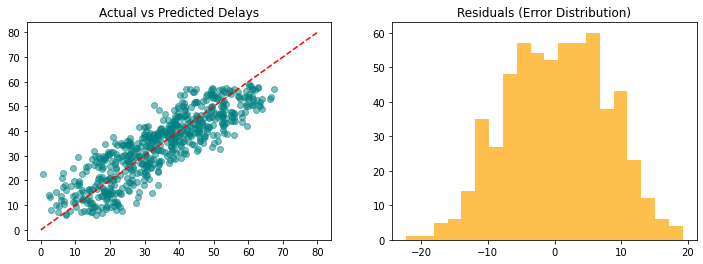

In [24]:
class PolynomialRegression:
    def __init__(self, degree=2): self.degree = degree
    def _transform(self, X):
        X_poly = X.copy()
        for d in range(2, self.degree + 1):
            X_poly = np.c_[X_poly, X**d]
        return np.c_[np.ones(len(X)), X_poly]
    
    def fit(self, X, y):
        X_p = self._transform(X)
        self.theta = np.linalg.pinv(X_p.T @ X_p) @ X_p.T @ y
        
    def predict(self, X):
        return self._transform(X) @ self.theta

poly_model = PolynomialRegression(degree=3)
poly_model.fit(X, y_reg)
y_pred = poly_model.predict(X)

# Better Evaluation: Predicted vs Actual + Residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(y_reg, y_pred, color='teal', alpha=0.5)
ax1.plot([0, 80], [0, 80], 'r--')
ax1.set_title("Actual vs Predicted Delays")
ax2.hist(y_reg - y_pred, bins=20, color='orange', alpha=0.7)
ax2.set_title("Residuals (Error Distribution)")
plt.show()

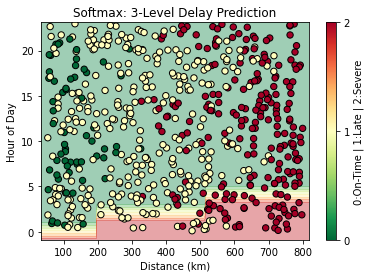

In [25]:
class SoftmaxRegression:
    def fit(self, X, y, lr=0.000001, iters=2000):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        self.W = np.zeros((n_features + 1, n_classes))
        X_b = np.c_[np.ones(n_samples), X]
        
        y_hot = np.eye(n_classes)[y]
        for _ in range(iters):
            scores = X_b @ self.W
            exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            self.W -= lr * X_b.T @ (probs - y_hot)
            
    def predict(self, X):
        X_b = np.c_[np.ones(len(X)), X]
        return np.argmax(X_b @ self.W, axis=1)

softmax_model = SoftmaxRegression()
softmax_model.fit(X, y_multi)
plot_multi_boundary(softmax_model, X, y_multi, "Softmax: 3-Level Delay Prediction")

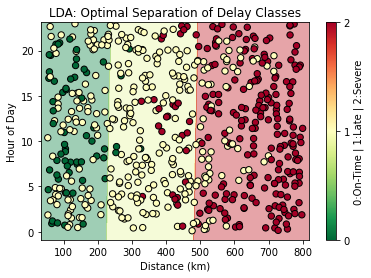

In [29]:
class LinearDiscriminantAnalysis:
    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)
        
        # Calculate mean vectors for each class
        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            # Within-class scatter matrix
            SW += (X_c - mean_c).T @ (X_c - mean_c)
            # Between-class scatter matrix
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff @ mean_diff.T)
        
        # Solve for eigenvectors of inv(SW) * SB
        A = np.linalg.pinv(SW) @ SB
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # Sort eigenvectors by eigenvalues
        idxs = np.argsort(abs(eigenvalues))[::-1]
        self.linear_discriminants = eigenvectors[:, idxs[0:len(class_labels)-1]]
        
        # For prediction in simple 2D space, we use class centroids
        self.centroids = [np.mean(X[y == c] @ self.linear_discriminants, axis=0) for c in class_labels]
        self.class_labels = class_labels

    def predict(self, X):
        X_projected = X @ self.linear_discriminants
        preds = []
        for x in X_projected:
            distances = [np.linalg.norm(x - centroid) for centroid in self.centroids]
            preds.append(self.class_labels[np.argmin(distances)])
        return np.array(preds)

# Usage
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X, y_multi)
plot_multi_boundary(lda_model, X, y_multi, "LDA: Optimal Separation of Delay Classes")

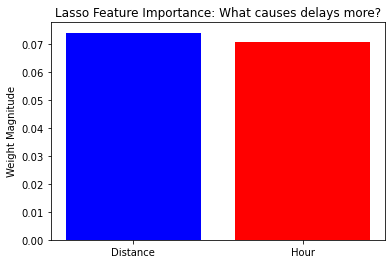

In [28]:
class LassoRegression:
    def fit(self, X, y, alpha=0.5, lr=0.000001, iters=2000):
        self.w = np.zeros(X.shape[1])
        self.b = 0
        for _ in range(iters):
            y_pred = X @ self.w + self.b
            dw = -(2 * X.T @ (y - y_pred)) / len(y) + alpha * np.sign(self.w)
            db = -2 * np.sum(y - y_pred) / len(y)
            self.w -= lr * dw
            self.b -= lr * db
            
    def predict(self, X): return X @ self.w + self.b

lasso = LassoRegression()
lasso.fit(X, y_reg)
features = ['Distance', 'Hour']
plt.bar(features, np.abs(lasso.w), color=['blue', 'red'])
plt.title("Lasso Feature Importance: What causes delays more?")
plt.ylabel("Weight Magnitude")
plt.show()

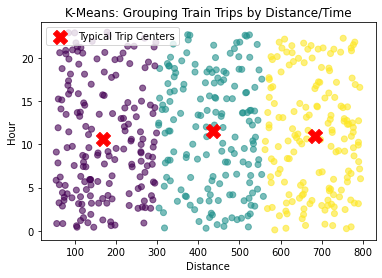

In [22]:
class KMeans:
    def __init__(self, k=3): self.k = k
    def fit(self, X, iters=20):
        self.centroids = X[np.random.choice(len(X), self.k, replace=False)]
        for _ in range(iters):
            self.labels = np.array([np.argmin(np.linalg.norm(x - self.centroids, axis=1)) for x in X])
            self.centroids = np.array([X[self.labels == i].mean(axis=0) for i in range(self.k)])
    def predict(self, X):
        return np.array([np.argmin(np.linalg.norm(x - self.centroids, axis=1)) for x in X])

km_model = KMeans(k=3)
km_model.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=km_model.labels, cmap='viridis', alpha=0.6)
plt.scatter(km_model.centroids[:,0], km_model.centroids[:,1], marker='X', s=200, c='red', label='Typical Trip Centers')
plt.title("K-Means: Grouping Train Trips by Distance/Time")
plt.xlabel("Distance")
plt.ylabel("Hour")
plt.legend()
plt.show()